# Modeling a Pincell
In this module, we'll demonstrate the basic features of the Python API for constructing input files and running OpenMC. In it, we will show how to create a basic reflective pincell model that is equivalent to modeling an infinite array of fuel pins in a pressurized water reactor. We highly recommend having a copy of the [Python API reference documentation](https://docs.openmc.org/en/stable/pythonapi/index.html) open in another browser tab that you can refer to.

<img src="pincell.png" alt="drawing" width="250"/>

For this example, we'll create a simple pincell that is composed of:
- UO<sub>2</sub> with 3.5 weight% enriched in U-235 at 11 g/cm<sup>3</sup>
- zirconium clad at 6.5 g/cm<sup>3</sup>
- H<sub>2</sub>O moderator at 1.0 g/cm<sup>3</sup>

The dimensions of our fuel pin will be as follows:
- Fuel outer radius = 0.46955 cm
- Clad inner radius = 0.47910 cm
- Clad outer radius = 0.54640 cm
- Fuel pin pitch = 1.44270 cm

In [3]:
import openmc

## Basics of Jupyter Notebook

You are working within a Jupyter notebook. Some common commands which will be useful:
- To execute a cell: `Shift+Enter`
- To insert a cell above or below: `Esc+a`, `Esc+b`

## Naming Conventions

Before we start working with OpenMC's Python API, it's helpful to understand the naming convention of objects so that you can conceptualize what is a function, what is a class, etc. OpenMC's Python interface follows the same naming convention that is adopted by many/most Python projects:

- Module names are `lowercase`
- Classes are `CamelCase`
- Functions and class attributes/variables are `lowercase_with_underscores`

To give a few specific examples:

- `openmc.deplete` is the depletion _module_
- `openmc.run` is a _function_
- `openmc.Material` is a _class_
- `openmc.StatePoint` is a _class_

## Setting Attributes

When building OpenMC models, we will work with many different classes. Each class typically has _attributes_, a variable belonging to the class. When creating a class, you can often set those attributes directly when you instantiate the object, like this:

In [5]:
my_cell = openmc.Cell()
my_cell.name = "box"

Or, you can assign values to attributes after you have already created the object. For example, the following is equivalent to the above:

In [6]:
my_other_cell = openmc.Cell(name="box2")
my_other_cell.temperature = 400

You can generally also mix-and-match, setting some attributes when you instantiate the object, and others at a later point.


## How to Get Help/Learn More

When building OpenMC models, we recommend having a copy of the Python API documentation (linked earlier) open. You can also query information about classes and methods directly from Jupyter. For example, we can use `help` to get documentation on all of the valid attributes for functions and classes.

In [7]:
help(openmc.Cell)

Help on class Cell in module openmc.cell:

class Cell(openmc.mixin.IDManagerMixin)
 |  Cell(cell_id=None, name='', fill=None, region=None)
 |  
 |  A region of space defined as the intersection of half-space created by
 |  quadric surfaces.
 |  
 |  Parameters
 |  ----------
 |  cell_id : int, optional
 |      Unique identifier for the cell. If not specified, an identifier will
 |      automatically be assigned.
 |  name : str, optional
 |      Name of the cell. If not specified, the name is the empty string.
 |  fill : openmc.Material or openmc.UniverseBase or openmc.Lattice or None or iterable of openmc.Material, optional
 |      Indicates what the region of space is filled with
 |  region : openmc.Region, optional
 |      Region of space that is assigned to the cell.
 |  
 |  Attributes
 |  ----------
 |  id : int
 |      Unique identifier for the cell
 |  name : str
 |      Name of the cell
 |  fill : openmc.Material or openmc.UniverseBase or openmc.Lattice or None or iterable of o

Attributes which have a default value will appear as `<attribute>=<the default value>` in the class/function definition. For example, in the above we see that the default name for a cell is the empty string, `''`.

For classes, all of the member functions you can access will then be defined further down, with their associated documentation. To see documentation for just one specific function, you can use syntax like:

In [9]:
help(my_cell.clone)

Help on method clone in module openmc.cell:

clone(clone_materials=True, clone_regions=True, memo=None) method of openmc.cell.Cell instance
    Create a copy of this cell with a new unique ID, and clones
    the cell's region and fill.
    
    Parameters
    ----------
    clone_materials : bool
        Whether to create separate copies of the materials filling cells
        contained in this cell, or the material filling this cell.
    clone_regions : bool
        Whether to create separate copies of the regions bounding cells
        contained in this cell, and the region bounding this cell.
    memo : dict or None
        A nested dictionary of previously cloned objects. This parameter
        is used internally and should not be specified by the user.
    
    Returns
    -------
    clone : openmc.Cell
        The clone of this cell



You can also query the type of a particular object using `type`. Note that we can also display the attributes for a particular object using `print`.

In [10]:
type(my_cell)

openmc.cell.Cell

In [11]:
print(my_cell)

Cell
	ID             =	2
	Name           =	box
	Fill           =	None
	Region         =	None
	Rotation       =	None
	Translation    =	None
	Volume         =	None



In order to quickly see all of the member functions on a class, press `Tab` to perform tab-completion to view a drop-down list on all the options available to you. You can then do `Shift+Tab` to see the documentation for each function inline.

In [ ]:
my_cell.

## OpenMC Model

The OpenMC `Model` class houses all of the pieces of a Monte Carlo simulation. We will assemble our pincell by progressively adding to a model, and then run that model.

In [12]:
model = openmc.Model()

In [13]:
print(model)

### The `cross_sections.xml` file

The `cross_sections.xml` tells OpenMC where it can find nuclide cross sections and $S(\alpha,\beta)$ tables. It serves the same purpose as MCNP's `xsdir` file and Serpent's `xsdata` file. As we mentioned, this can be set either by the `OPENMC_CROSS_SECTIONS` environment variable or the `Materials.cross_sections` attribute.

Let's have a look at what's inside this file:

In [14]:
!cat $OPENMC_CROSS_SECTIONS | head -n 10


<?xml version='1.0' encoding='utf-8'?>
<cross_sections>
  <library materials="H1" path="neutron/H1.h5" type="neutron" />
  <library materials="H2" path="neutron/H2.h5" type="neutron" />
  <library materials="H3" path="neutron/H3.h5" type="neutron" />
  <library materials="He3" path="neutron/He3.h5" type="neutron" />
  <library materials="He4" path="neutron/He4.h5" type="neutron" />
  <library materials="Li6" path="neutron/Li6.h5" type="neutron" />
  <library materials="Li7" path="neutron/Li7.h5" type="neutron" />
  <library materials="Be7" path="neutron/Be7.h5" type="neutron" />


In [15]:
!cat $OPENMC_CROSS_SECTIONS | tail -n 10

  <library materials="Cf253" path="wmp/098253.h5" type="wmp" />
  <library materials="Cf254" path="wmp/098254.h5" type="wmp" />
  <library materials="Es251" path="wmp/099251.h5" type="wmp" />
  <library materials="Es252" path="wmp/099252.h5" type="wmp" />
  <library materials="Es253" path="wmp/099253.h5" type="wmp" />
  <library materials="Es254" path="wmp/099254.h5" type="wmp" />
  <library materials="Es254_m1" path="wmp/099254m1.h5" type="wmp" />
  <library materials="Es255" path="wmp/099255.h5" type="wmp" />
  <library materials="Fm255" path="wmp/100255.h5" type="wmp" />
</cross_sections>


## Defining Materials

Materials in OpenMC are defined as a set of nuclides with specified atom/weight fractions. To begin, we will create a material by making an instance of the `Material` class. In OpenMC, many objects, including materials, are identified by a "unique ID" (a positive integer). You can also give a material a `name` as well.

In [16]:
zirconium = openmc.Material()

In [17]:
print(zirconium)

Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       



One great feature in OpenMC's design is that the user interaction is designed to be as streamlined as possible. You don't *need* to set either an ID or a name (because often you can simply refer to an object with the actual object handle). If you were to create a material without any ID, OpenMC will assign a default for you.

In [18]:
zirconium.add_element('Zr', 1.0)

In [19]:
print(zirconium)

Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]



We see that an ID of 2 was automatically assigned. Let's now move on to adding nuclides to our material. The `Material` object has a method `add_element()` whose first argument is the name of the nuclide and second argument is the atom or weight fraction. We see that by default it assumes we want an atom fraction.

In [20]:
zirconium.set_density('g/cm3', 6.5)

In [21]:
print(zirconium)

Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	6.5 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]



### Element Expansion
We can see that OpenMC automatically inserted the natural abundances of the zirconium isotopes for us! How convenient! The way this feature works is as follows:

- First, it checks whether `Materials.cross_sections` has been set, indicating the path to a `cross_sections.xml` file.
- If `Materials.cross_sections` isn't set, it looks for the `OPENMC_CROSS_SECTIONS` environment variable.
- If either of these are found, it scans the file to see what nuclides are actually available and will expand elements accordingly.

Let's build our fuel material. For sake of illustration, let's suppose that we had O-16, but not natural oxygen in our fuel. Also note that OpenMC has a convenient feature to set the nuclide concentrations for weight percent enrichments in U-235.

In [22]:
uo2 = openmc.Material(name="uo2")

In [24]:
uo2.add_nuclide('O16', 2.0)
print(uo2)

Material
	ID             =	2
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	O16            =	2.0          [ao]
	O16            =	2.0          [ao]



In [25]:
uo2.add_element('U', 1.0, enrichment=3.5)

In [26]:
print(uo2)

Material
	ID             =	2
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	O16            =	2.0          [ao]
	O16            =	2.0          [ao]
	U234           =	0.0003166930253944235 [ao]
	U235           =	0.03543164439454172 [ao]
	U238           =	0.964089368630351 [ao]
	U236           =	0.00016229394971280895 [ao]



In [27]:
uo2.set_density('g/cm3', 10.0)

With UO2 finished, let's now create materials for the coolant.

In [28]:
water = openmc.Material()
water.add_element('H', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('kg/m3', 1000.0)

An astute observer might now point out that this water material we just created will only use free-atom cross sections. We need to tell it to use an $S(\alpha,\beta)$ table so that the bound atom cross section is used at thermal energies. To do this, there's an `add_s_alpha_beta()` method.

In [29]:
water.add_s_alpha_beta('c_H_in_H2O')

In [30]:
print(water)

Material
	ID             =	3
	Name           =	
	Temperature    =	None
	Density        =	1000.0 [kg/m3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]
	O16            =	1.0          [ao]



We are done with our materials -- now we just need to register them in our model.

In [31]:
model.materials = openmc.Materials([uo2, zirconium, water])

### Material Modifications

The power of OpenMC's Python API is the ability to easily modify and control your model.

In [32]:
print(water)

Material
	ID             =	3
	Name           =	
	Temperature    =	None
	Density        =	1000.0 [kg/m3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]
	O16            =	1.0          [ao]



In [33]:
water.remove_nuclide('O16')
print(water)

Material
	ID             =	3
	Name           =	
	Temperature    =	None
	Density        =	1000.0 [kg/m3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]



In [35]:
water.add_element('O', 1.0)
print(water)

Material
	ID             =	3
	Name           =	
	Temperature    =	None
	Density        =	1000.0 [kg/m3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]
	O16            =	0.999621     [ao]
	O17            =	0.000379     [ao]
	O16            =	0.999621     [ao]
	O17            =	0.000379     [ao]



We see that now O16 and O17 were automatically added. O18 is missing because our cross sections file (which is based on ENDF/B-VII.1) doesn't have O18.

### Python Lists

Many of OpenMC's classes are derived from Python's `list` type, and can therefore be appended, popped, etc.

In [36]:
new_fuel = openmc.Material()
new_fuel.add_nuclide('Pu239', 1.0)
new_fuel.add_nuclide('Si28', 2.0)


In [37]:
model.materials.append(new_fuel)

In [38]:
print(model.materials)

[Material
	ID             =	2
	Name           =	uo2
	Temperature    =	None
	Density        =	10.0 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	O16            =	2.0          [ao]
	O16            =	2.0          [ao]
	U234           =	0.0003166930253944235 [ao]
	U235           =	0.03543164439454172 [ao]
	U238           =	0.964089368630351 [ao]
	U236           =	0.00016229394971280895 [ao]
, Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	6.5 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]
, Material
	ID             =	3
	Name           =	
	Temperature    =	None
	Density        =	1000.0 [kg/m3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)     

## Defining Geometry

We now need to define the geometry. One way to do so is to use constructive solid geometry (CSG), also known as combinatorial geometry. The object that allows us to assign a material to a region of space is called a `Cell` (same concept in MCNP, for those familiar). There are four stages in building a cell:

#### Surfaces
In order to define a region that we can assign to a cell, we must first define surfaces which bound the region. A *surface* is a locus of zeros of a function of Cartesian coordinates $x$, $y$, and $z$, e.g.

- A plane perpendicular to the x axis: $x - x_0 = 0$
- A cylinder parallel to the z axis: $(x - x_0)^2 + (y - y_0)^2 - R^2 = 0$
- A sphere: $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 - R^2 = 0$

The full [list of available surfaces](https://docs.openmc.org/en/stable/pythonapi/base.html#building-geometry) is as follows.

Planes:

- `openmc.Plane` — An arbitrary plane of the form $Ax + By + Cz = D$
- `openmc.XPlane` — A plane perpendicular to the x axis of the form $x - x_0 = 0$
- `openmc.YPlane` — A plane perpendicular to the y axis of the form $y - y_0 = 0$
- `openmc.ZPlane` — A plane perpendicular to the z axis of the form $z - z_0 = 0$

Quadrics:

- `openmc.XCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(y - y_0)^2 + (z - z_0)^2 = r^2$
- `openmc.YCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(x - x_0)^2 + (z - z_0)^2 = r^2$
- `openmc.ZCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(x - x_0)^2 + (y - y_0)^2 = r^2$
- `openmc.Sphere` — A sphere of the form $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 = r^2$
- `openmc.XCone` — A cone parallel to the x-axis of the form $(y - y_0)^2 + (z - z_0)^2 = r^2 (x - x_0)^2$
- `openmc.YCone` — A cone parallel to the y-axis of the form $(x - x_0)^2 + (z - z_0)^2 = r^2 (y - y_0)^2$
- `openmc.ZCone` — A cone parallel to the z-axis of the form $(x - x_0)^2 + (y - y_0)^2 = r^2 (z - z_0)^2$
- `openmc.Quadric` — A generic quadric surface

Torii:

- `openmc.XTorus` — A torus of the form $(x - x_0)^2/B^2 + (\sqrt{(y - y_0)^2 + (z - z_0)^2} - A)^2/C^2 - 1 = 0$
- `openmc.YTorus` — A torus of the form $(y - y_0)^2/B^2 + (\sqrt{(x - x_0)^2 + (z - z_0)^2} - A)^2/C^2 - 1 = 0$
- `openmc.ZTorus` — A torus of the form $(z - z_0)^2/B^2 + (\sqrt{(x - x_0)^2 + (y - y_0)^2} - A)^2/C^2 - 1 = 0$

#### Half-Spaces

<img src="csg_half.png" alt="drawing" width="600"/>

A surface *half-space* is the region whose points satisfy a positive or negative inequality of the surface equation. For example, for a sphere of radius one centered at the origin, the surface equation is $f(x,y,z) = x^2 + y^2 + z^2 - 1 = 0$. Thus, we say that the negative half-space of the sphere is defined as the collection of points satisfying $f(x,y,z) < 0$, which one can reason is the inside of the sphere. Conversely, the positive half-space of the sphere would correspond to all points outside of the sphere.

#### Regions
A region is then a combination of (or just one) half-spaces.

#### Fills
Finally, a cell is complete once we have defined what is _filling_ the cell, which may be one of:

- material
- nothing (`None`), or vacuum/void
- universe
- lattice

In [39]:
sphere = openmc.Sphere(r=1.0)

Note that by default the sphere is centered at the origin so we didn't have to supply `x0`, `y0`, or `z0` arguments. Strictly speaking, we could have omitted `r` as well since it defaults to one. To get the negative or positive half-space, we simply need to apply the `-` or `+` unary operators, respectively.

In [40]:
inside_sphere = -sphere

In [41]:
outside_sphere = +sphere

Now let's see if `inside_sphere` actually contains points inside the sphere:

In [44]:
print((0, 0.1, 0.1) in inside_sphere)
print((100.0, 3, -5) in outside_sphere)

True
True


Everything works as expected! Now that we understand how to create half-spaces, we can create more complex volumes by combining half-spaces using Boolean operators: `&` (intersection), `|` (union), and `~` (complement):

- `&`: logical AND
- `|`: logical OR
- `~`: logical NOT

For example, let's say we want to define a region that is the top part of the sphere (all points inside the sphere that have $z > 0$.

In [45]:
z_plane = openmc.ZPlane(z0=0)

In [46]:
northern_hemisphere = -sphere & +z_plane

In [47]:
cell = openmc.Cell()
cell.region = northern_hemisphere
cell.fill = water

### Universes and in-line plotting

A collection of cells is known as a universe and can be used as a repeatable unit when creating a model. Although we don't need it yet, the benefit of creating a universe is that we can visualize our geometry while we're creating it.

In [48]:
universe = openmc.Universe()
universe.add_cell(cell)

The `Universe` object has a `plot` method that will display our the universe as current constructed:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

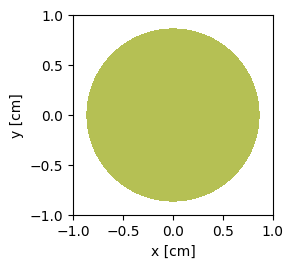

In [49]:
universe.plot(width=(2.0, 2.0))

By default, the plot will appear in the $x$-$y$ plane. We can change that with the `basis` argument.

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

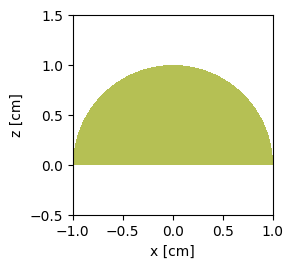

In [50]:
universe.plot(width=(2.0, 2.0), basis='xz')

If we have particular fondness for, say, fuchsia, we can tell the `plot()` method to make our cell that color.

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

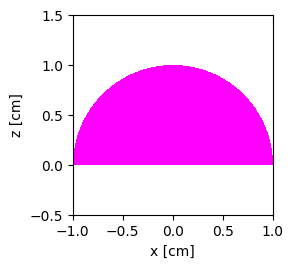

In [51]:
universe.plot(width=(2.0, 2.0), basis='xz', colors={cell: 'fuchsia'})

### Boundary Conditions

To specify boundary conditions, you simply need to set the `Surface.boundary_type` to one of:

- `transmission` (default)
- `vacuum`
- `reflective`
- `periodic` (either rotational or translational)
- `white` (isotropic angular flux)

<img src="mc_bcs.png" alt="drawing" width="600"/>

In [53]:
sphere.boundary_type = 'vacuum'
z_plane.boundary_type = 'vacuum'

### Pin cell geometry

We now have enough knowledge to create our pin-cell. We need three surfaces to define the fuel and clad:

1. The outer surface of the fuel -- a cylinder parallel to the z axis
2. The inner surface of the clad -- same as above
3. The outer surface of the clad -- same as above

These three surfaces will all be instances of `openmc.ZCylinder`, each with a different radius according to the specification.

In [54]:
radii = [0.46955, 0.47910, 0.54640]
cylinders = []
for r in radii:
    cylinders.append(openmc.ZCylinder(r=r))

With the surfaces created, we can now take advantage of the built-in operators on surfaces to create regions for the fuel, the gap, and the clad:

In [56]:
fuel_region = -cylinders[0]
gap_region = +cylinders[0] & -cylinders[1]
clad_region = +cylinders[1] & -cylinders[2]

We will also create two z-planes in order to bound the geometry in the axial direction.

In [57]:
top = openmc.ZPlane(z0=150, boundary_type='vacuum')
bottom = openmc.ZPlane(z0=-150, boundary_type='vacuum')
layer = +bottom & -top

Now we can create corresponding cells that assign materials to these regions. As with materials, cells have unique IDs that are assigned either manually or automatically. Note that the gap cell doesn't have any material assigned (it is void, a.k.a. vacuum, by default).

In [58]:
fuel = openmc.Cell()
fuel.region = fuel_region & layer
fuel.fill = uo2

gap = openmc.Cell()
gap.region = gap_region & layer

clad = openmc.Cell()
clad.region = clad_region & layer
clad.fill = zirconium

Finally, we need to handle the coolant outside of our fuel pin. To do this, we create x- and y-planes that bound the geometry.

In [59]:
pitch = 1.44270
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
front = openmc.YPlane(-pitch/2, boundary_type='reflective')
back = openmc.YPlane(pitch/2, boundary_type='reflective')

The water region is going to be everything outside of the clad outer radius and within the box formed as the intersection of four half-spaces.

In [60]:
water_region = +left & -right & +front & -back & layer & +cylinders[2]

In [61]:
moderator = openmc.Cell()
moderator.fill = water
moderator.region = water_region

The final step is to assign the cells we created to a universe and tell OpenMC that this universe is the "root" universe in our geometry.

In [62]:
root_universe = openmc.Universe()
root_universe.add_cells([fuel, gap, clad, moderator])

In [63]:
model.geometry = openmc.Geometry(root_universe)

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

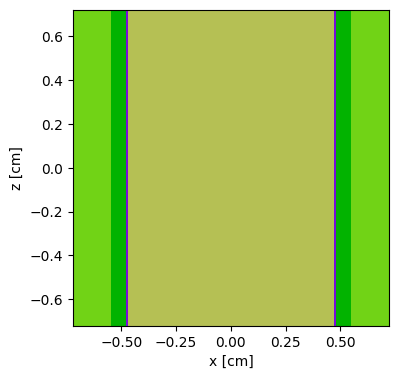

In [66]:
root_universe.plot(width=(pitch, pitch), pixels=100000, basis='xz')

## Starting source and settings

The Python API has a module `openmc.stats` with various univariate and multivariate probability distributions. We can use these distributions to create a starting source using the `openmc.Source` object. One can independently specify the spatial distribution (`space`), the angular distribution (`angle`), the energy distribution (`energy`), and the time distribution (`time`). For this example, we'll only specify the spatial distribution as a single point.

In [67]:
point = openmc.stats.Point()
source = openmc.IndependentSource(space=point)

In [68]:
model.settings.source = source
model.settings.particles = 1000
model.settings.inactive = 10
model.settings.batches = 100

## Running OpenMC

Running OpenMC from Python can be done using the `model.run()` function. This function allows you to set the number of MPI processes and OpenMP threads, if need be.

In [69]:
statepoint = openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      101/1    1.37973    1.42730 +/- 0.00555
      102/1    1.44792    1.42752 +/- 0.00550
      103/1    1.48616    1.42815 +/- 0.00547
      104/1    1.44757    1.42836 +/- 0.00542
      105/1    1.46235    1.42872 +/- 0.00537
 Triggers unsatisfied, no result tallied for score kappa-fission in tally 10
      106/1    1.42341    1.42866 +/- 0.00532
      107/1    1.50985    1.42950 +/- 0.00533
      108/1    1.44734    1.42968 +/- 0.00528
      109/1    1.45715    1.42996 +/- 0.00523
      110/1    1.47210    1.43038 +/- 0.00520
 Triggers unsatisfied, no result tallied for score kappa-fission in tally 10
      111/1    1.33657    1.42945 +/- 0.00523
      112/1    1.38688    1.42903 +/- 0.00519
      113/1    1.35645    1.42833 +/- 0.00519
      114/1    1.47936    1.42882 +/- 0.00516
      115/1    1.39422    1.42849 +/- 0.00512
 Triggers unsatisfied, no result tallied for score kappa-fission in tally 10
      116/1    1.43675    1.42857 +/- 0.00508
      117/1    1.40023    1.42830

## Geometry plotting

We saw before that we could call the `Universe.plot()` method to show a universe while we were creating our geometry. There is also a built-in plotter in the codebase that is much faster than the Python plotter and has more options. The interface looks somewhat similar to the `Universe.plot()` method. Instead though, we create `Plot` instances, assign them to a `Plots` collection, export it to XML, and then run OpenMC in geometry plotting mode. As an example, let's specify that we want the plot to be colored by material (rather than by cell) and we assign yellow to fuel and blue to water.

With our plot created, we need to add it to a `Plots` collection which can be exported to XML.

Now we can run OpenMC in plotting mode by calling the `plot_geometry()` function.

Now, we can use functionality from IPython to display the `.png` image inline in our notebook:

## Tallies

In this section, we'll be looking at how to extract custom information from an OpenMC simulation in what is known as a "tally." A tally accumulates statistical information during the simulation about particles when they eneter regions of phase space specified on the tally. The limits of these regions are set by "filters" applied to the tally. Scores and nuclides can also be applied to tallies to indicate what type of information is kept about the particle (e.g. reaction types, flux, heat, etc.).

Any tally in OpenMC can be described with the following form:

$$ 
 X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
    dE}_{\text{filters}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
    E)}_{\text{scores}} \underbrace{\psi (\mathbf{r}, \mathbf{\Omega}, E)}_{\text{angular flux}}
$$

where filters set the limits of the integrals and the scoring function is convolved with particle information (e.g. reaction type, current material, etc.). For example, if you wanted to calculate the fission reaction rate caused by fast neutrons in cell 3, your tally becomes

$$ 
 X = \int_\text{cell 3} d\mathbf{r} \int_{4\pi} d\mathbf{\Omega} \int_{1 MeV}^{20 MeV}
    dE \ \ \Sigma_f(\mathbf{r}, \mathbf{\Omega},
    E) \psi (\mathbf{r}, \mathbf{\Omega}, E)
$$

<div class="alert alert-block alert-info">
A full list of scores and their meanings can be found <a href=https://docs.openmc.org/en/stable/usersguide/tallies.html#scores >here</a>.
</div>

In this exercise we'll be adding tallies to perform a few different tasks:


  **1. Determine the energy and heat produced per fission** \
  **2. Plot the flux spectrum of the pincell** \
  **3. Plot reaction types based on material**
  
First, to determine the recoverable energy produced per fission we'll create a tally without filters to gather information on the fission reaction rate ("`fission`") and recoverable fission energy ("`kappa-fission`"). Because we want this information talllied throughout the model, a "global" tally, no filters need to be applied.

### Task 1: Energy released per fission

In [70]:
tally1 = openmc.Tally()


In [71]:
tally1.scores = ['fission', 'kappa-fission']

In [72]:
model.tallies = openmc.Tallies([tally1])

Now, we can simply re-run our model with this additional tally.

In [73]:
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

If we list our current directory, we see that several new files have been created as a result of this run: `summary.h5`, `tallies.out`, and `statepoint.50.h5`. The `tallies.out` file contains a text output of all user-specified tallies for the simulation. The summary file contains information about the simulation's setup (geometry, materials, meshes, etc.) in an HDF5 format.

In [74]:
!cat tallies.out

 ============================>     TALLY 1     <============================

 Total Material
   Fission Rate                         0.531407 +/- 0.00244115
   Kappa-Fission Rate                   1.02915e+08 +/- 472219


This can be useful to quickly look at simple tally results, but isn't a great format to post-process simulation data. For that we'll look to the statepoint file. The statepoint file contains information about simulation results including tally specifications and data.

In [75]:
print(statepoint)

/Users/anovak/projects/openmc/statepoint.100.h5


To extract information from the statepoint file we'll create an `openmc.StatePoint` object. The `statepoint.get_tally` function will search for tallies by scores, filters, nuclides, ids, and return the closest match. Exact matches can be speficied as well.

In [76]:
with openmc.StatePoint(statepoint) as sp:
    my_tally = sp.get_tally(id=tally1.id)

In [77]:
print(my_tally)

Tally
	ID             =	1
	Name           =	
	Filters        =	
	Nuclides       =	total
	Scores         =	['fission', 'kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True


<div class="alert alert-block alert-info">
<b>A quick aside on how statepoint objects interact with summary files:</b>


The `openmc.statepoint` object will read information from the `summary.h5` file if one is present, keeping that file open in the Python interpreter. The open `summary.h5` file can interfere with the initialization of subsequent OpenMC simulations. It is recommended that information be extracted from statepoints within a [context manager](https://book.pythontips.com/en/latest/context_managers.html) as we do here. Alternatively, making sure to call the `openmc.StatePoint.close` method will work also. For more details please look to the [relevant section in the user's guide](https://docs.openmc.org/en/stable/usersguide/troubleshoot.html#runtimeerror-failed-to-open-hdf5-file-with-mode-w-summary-h5).   
</div>

To compute the energy released per fission event, we can simply take the tallied energy released per fission and divide it by the fission rate.

In [79]:
my_tally.get_values()
print(my_tally.shape)

(1, 1, 2)


In [83]:
fission_rate = my_tally.get_values(scores=['fission']).flatten()[0]
kappa_fission_rate = my_tally.get_values(scores=['kappa-fission']).flatten()[0]
print(fission_rate)

0.5314066016390909


In [84]:
print(kappa_fission_rate/fission_rate * 1e-6)

193.6649812968026


In [85]:
dfission_rate = my_tally.get_values(scores=['fission'], value='std_dev').flatten()[0]
dkappa_fission_rate = my_tally.get_values(scores=['kappa-fission'], value='std_dev').flatten()[0]

from uncertainties import ufloat
f = ufloat(fission_rate, dfission_rate)
kf = ufloat(kappa_fission_rate, dkappa_fission_rate)

print(kf/f * 1e-6)

193.7+/-1.3


As with most values coming out of an MC code, these values are per source-particle. In this case these units cancel out, but this will not be the case in our next example.

### Task 2: Plot the neutron flux spectrum

To perform this task, we'll be applying a tally with an energy filter and a score. OpenMC's data module contains different group structures. For this problem we'll use the CASMO-70 group structure. An energy filter can easily be created from a pre-defined group structure in OpenMC as follows:

In [86]:
print(openmc.mgxs.GROUP_STRUCTURES.keys())

dict_keys(['CASMO-2', 'CASMO-4', 'CASMO-8', 'CASMO-16', 'CASMO-25', 'CASMO-40', 'VITAMIN-J-42', 'SCALE-44', 'MPACT-51', 'MPACT-60', 'MPACT-69', 'CASMO-70', 'XMAS-172', 'VITAMIN-J-175', 'SCALE-252', 'TRIPOLI-315', 'SHEM-361', 'CCFE-709', 'UKAEA-1102', 'ECCO-1968'])


In [87]:
energy_filter = openmc.EnergyFilter.from_group_structure('CASMO-70')

In [88]:
len(energy_filter.bins)

70

In [89]:
spectrum_tally = openmc.Tally()
spectrum_tally.filters = [energy_filter]
spectrum_tally.scores = ['flux']

In [90]:
model.tallies += [spectrum_tally]

In [91]:
statepoint = model.run()


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [92]:
!cat tallies.out

 ============================>     TALLY 1     <============================

 Total Material
   Fission Rate                         0.531407 +/- 0.00244115
   Kappa-Fission Rate                   1.02915e+08 +/- 472219
 ============================>     TALLY 2     <============================

 Incoming Energy [0, 0.005)
   Total Material
     Flux                                 0.0326954 +/- 0.000771586
 Incoming Energy [0.005, 0.01)
   Total Material
     Flux                                 0.0919574 +/- 0.00149492
 Incoming Energy [0.01, 0.015)
   Total Material
     Flux                                 0.134869 +/- 0.00171544
 Incoming Energy [0.015, 0.02)
   Total Material
     Flux                                 0.166044 +/- 0.00203603
 Incoming Energy [0.02, 0.025)
   Total Material
     Flux                                 0.186206 +/- 0.00247867
 Incoming Energy [0.025, 0.03)
   Total Material
     Flux                                 0.198609 +/- 0.00250393
 Incoming E

In [94]:
with openmc.StatePoint(statepoint) as sp:
    my_tally = sp.get_tally(id=spectrum_tally.id)

In [96]:
print(my_tally.shape)
values = my_tally.get_values().flatten()
print(values)

(70, 1, 1)
[0.03269539 0.09195735 0.13486934 0.16604364 0.18620596 0.19860941
 0.20714537 0.2999926  0.32710021 0.30804559 0.30973833 0.39564545
 0.4840768  0.66333518 0.42890704 0.30575361 0.18846799 0.16020141
 0.0978352  0.09213013 0.12523407 0.19216422 0.32883252 0.32936496
 0.31560947 0.123314   0.09709005 0.05984065 0.03494564 0.0357701
 0.03451336 0.03526823 0.03452356 0.03252371 0.03161864 0.0316335
 0.1748434  0.20413153 0.3091616  0.17422272 0.30248679 0.33513843
 0.26227539 1.14636151 0.72434495 0.80319884 0.87526576 0.77762522
 1.22801235 1.71794335 1.79090279 0.93730087 0.96052514 0.95260227
 0.98894661 1.11803462 1.15858124 1.229531   1.32456639 1.46160922
 1.73894145 2.08858341 2.74838695 2.69801325 4.38596931 3.38687972
 3.72822046 3.52515721 1.53549944 0.33954751]


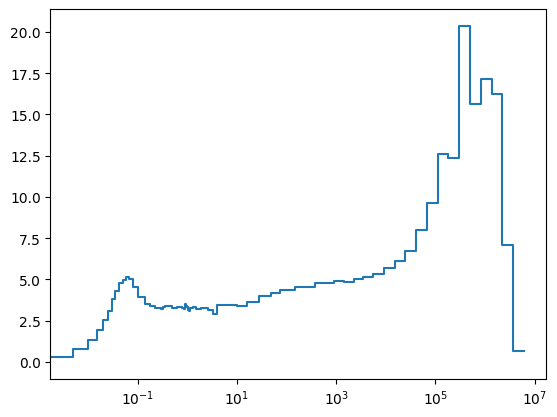

In [99]:
import matplotlib.pyplot as plt
import numpy as np

bin_boundaries = energy_filter.lethargy_bin_width

plt.step(np.unique(energy_filter.bins)[:-1], values/bin_boundaries)
plt.xscale('log')
plt.show()

### Normalizing Tallies

Note that the units of flux in the above plot are in $\frac{particle-cm}{source-particle}$. As is the case with many values tallied by Monte Carlo codes, the value of the flux does not account for volume and is in terms of the number of source particles emitted. To generate this same plot in terms of absolute flux units ($\frac{particle}{cm^{2}-s}$) we'll need to normalize this tally by:

  - the volume of the region the tally covers
  - the number of source particle emitted

In this case, the volume of the region is the volume of the entire pincell, which we can obtain using a bounding box (or the dimensions we set earlier, but let's introduce the notion of a bounding box!)

Determining the number of source particles per second is more complicated, however. This means computing the eV/source particle due to fission. To get the source rate, we'll need the following pieces of information:

  1. the total power produced in the tally region (known a priori)
  2. the heat produced by fission power, per source particle
  
 To get this information we'll need to construct another tally to get additional information from the simulation.

The combination of the following tally values and power provide us with the source normalization needed as follows:


$$ \text{neutron source} [\frac{n}{s}] = \text{power} [\frac{J}{s}] \times \frac{1}{1.6\times 10^{-19}} [\frac{eV}{J}] \times \frac{1}{\text{heat per fission} [\frac{eV}{source}]} $$ 

### Task 3: Reaction Types by Material

Looking at the different reaction types by material will require a material filter and the set of reaction types we want to score. For this example, we'll be scoring absorption, scattering and fission in each material.

To start, we'll create a material filter.

Now we'll gather information from the statepoint file about each score we applied to the tally. With multiple scores and materials, we'll use a Pandas data frame to view the results in a more coherent manner.

We'll add a new entry in the dataframe for our material names to make plotting easier.

### Task 4: Mesh Tallies

In order to restrict a tally to a particular region in space, OpenMC supports (i) cell, (ii) structured mesh, and (iii) unstructured mesh tallies. For unstructured mesh tallies, you need to compile OpenMC with libMesh enabled. We don't have this dependency set up on the Collab instance, so we'll just work with structured mesh tallies.

In [100]:
mesh = openmc.RegularMesh()

In [101]:
mesh.lower_left = (-pitch/2, -pitch/2)
mesh.upper_right = (pitch/2, pitch/2)
mesh.dimension = (50, 50)

In [102]:
mesh_filter = openmc.MeshFilter(mesh)

In [103]:
heat = openmc.Tally()
heat.scores = ['kappa-fission']
heat.filters = [mesh_filter]
model.tallies.append(heat)

In [104]:
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [105]:
with openmc.StatePoint(statepoint) as sp:
    mesh_tally = sp.get_tally(id=heat.id)

In [106]:
values = mesh_tally.get_values()

In [109]:
print(values.shape)
values = values.reshape((50, 50))
print(values.shape)

(50, 50)
(50, 50)


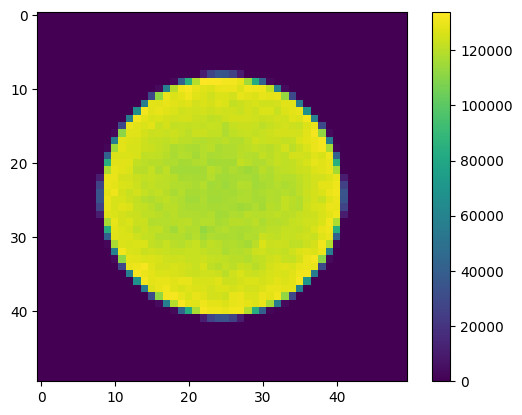

In [111]:
plt.figure()
img = plt.imshow(values)
plt.colorbar(img)

/Users/anovak/projects/openmc/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]


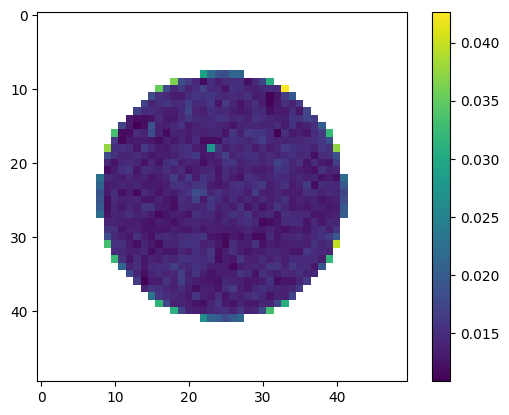

In [114]:
values = mesh_tally.get_values(value='rel_err')
values = values.reshape((50, 50))
plt.figure()
img = plt.imshow(values)
plt.colorbar(img)

## Universes

A universe is a collection of cells that can be used as a repeatable unit in the geometry. At a minimum, there must be one "root" universe (say, named `root`), which gets passed to `openmc.Geometry(root)`. But you can also use universes to repeat a collection of cells multiple times throughout a geometry. Here, we will explore some basic features of universes.

We'll start by making a universe which looks similar to the pincell we built earlier - say, a cylinder of UO2 enclosed by an infinite region of water. First, we set up our materials and create our geometry.

In [115]:
pin = openmc.ZCylinder(r=1)
pin_cell = openmc.Cell(region=-pin, fill=uo2)
outside_cell = openmc.Cell(region=~(-pin), fill=water)

In [116]:
u = openmc.Universe()
u.add_cells([pin_cell, outside_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

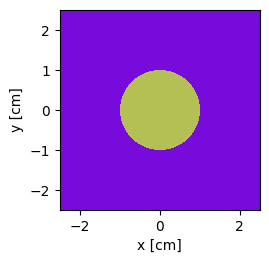

In [117]:
u.plot(width=(5, 5))

In [118]:
big_cylinder = openmc.ZCylinder(r=5)
big_cell = openmc.Cell(region=-big_cylinder)

In [119]:
big_cell.fill = u

We have created a universe containing a pin, enclosed in an infinite medium of water. Now let's suppose that I want to fill this universe into an enclosing cell, a cylinder of radius 5 cm. Let's first create this cylinder, and then we will fill it with our `universe`.

In [120]:
big_universe = openmc.Universe(cells=[big_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

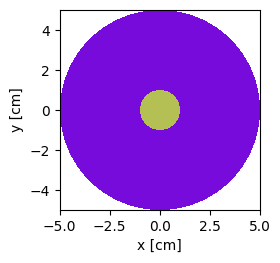

In [121]:
big_universe.plot(width=(10, 10))

Let's take a look at our geometry. In order to visualize at this stage, we need to create a universe from our `big_cell`.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

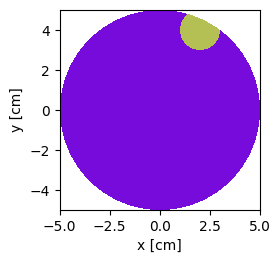

In [122]:
pin.x0 = 2
pin.y0 = 4
big_universe.plot(width=(10, 10))

We can see that our `big_cell`, the large cylinder, has been filled with the `universe` we declared earlier. Let's increase the complexity a bit to understand how this filling works. What if the cylinder of UO2 in our `universe` is not located at the origin, but is instead shifted to a different position?

We see that when we fill a universe inside of another cell, that there's (by default) no transformation of coordinates. You can shift the position of the universe filling a cell with the `Cell.translation` attribute. There are similar adjustments you can make, like rotations.

## Lattices

Lattices are a convenient way to (i) repeat a universe multiple times in space, while (ii) automatically translating that universe's origin to different positions in space. In order to explore this concept, let's work with a PWR fuel assembly.

We will make individual universes for each repeatable unit in the assembly design.

### Fuel Pin

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

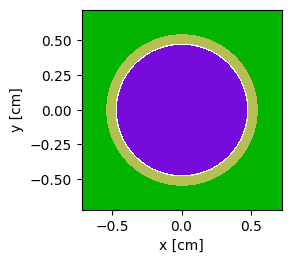

In [129]:
fuel_u = root_universe
fuel_u.plot(width=(pitch, pitch), color_by='material')

### Guide Tube

In [125]:
guide_ir = openmc.ZCylinder(r=0.45)
guide_or = openmc.ZCylinder(r=0.5)
inner = openmc.Cell(fill=water, region=-guide_ir)
clad2 = openmc.Cell(fill=zirconium, region=+guide_ir & -guide_or)
guide_outer = openmc.Cell(fill=water, region=+guide_or)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

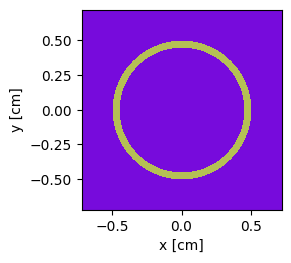

In [128]:
guide_u = openmc.Universe(cells=[inner, clad2, guide_outer])
guide_u.plot(width=(pitch, pitch), color_by='material')

Now we are ready to build our fuel assembly, by stamping these two universes into a repeatable pattern. OpenMC has `RectLattice` and `HexLattice` objects, to create lattices on a Cartesian grid or on a hexagonal grid. For our fuel assembly, we need to use `RectLattice`. 

When creating a rectangular lattice, we need to define:

1. The lower-left coordinates of the lattice (`.lower_left`)
2. The size of each lattice element (`.pitch`)
3. The 2D arrangement of universes (`.universes`)
4. (_optionally_) A universe that is used outside of the defined region (`.outer`)

In [142]:
lattice = openmc.RectLattice()
print(pitch)

1.4427


To plot the lattice, we need to put it in a universe. For this, we'll create a single cell filled with the lattice, and then put that single cell inside a universe to plot:

In [144]:
lattice.lower_left = (-pitch, -pitch)
lattice.pitch = (pitch, pitch)

In [145]:
lattice.universes = [
    [fuel_u, fuel_u],
    [guide_u, fuel_u]
]

lattice.outer = openmc.Universe(cells=[openmc.Cell(fill=water)])

Universe
	ID             =	20
	Name           =	
	Geom           =	CSG
	Cells          =	[27]



<Axes: xlabel='x [cm]', ylabel='y [cm]'>

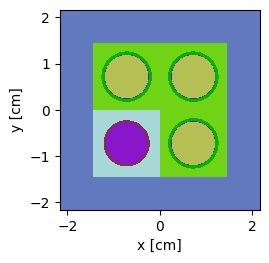

In [146]:
uni = openmc.Universe(cells=[openmc.Cell(fill=lattice)])
print(uni)
uni.plot(width=(pitch*3,pitch*3))

### What exactly does `outer` mean?

In the previous section, we set the lattice outer universe to a universe containing a single cell with only water in it. To get a better sense of what the outer universe does, let's change the outer universe to the guide tube universe:

### 17x17 Fuel Assembly

Now we just have to add the boundary conditions and root universe to finish the geometry. To create a box containing the lattice, we'll use the `rectangular_prism` function:

## TRISO Particles

OpenMC includes a few convenience functions for generating locations of randomly packed spheres that can be used to model TRISO particles and/or pebbles in a reactor core. To be clear, this capability is not a stochastic geometry capability like that included in MCNP. It's also important to note that OpenMC does not use delta tracking, which would normally speed up calculations in geometries with tons of surfaces and cells. However, the computational burden can be eased by placing random spheres in a lattice.

This capability relies on three functions/classes:
- `openmc.model.pack_spheres` -- generate locations of random spheres
- `openmc.model.TRISO` -- Cell-like object that holds a universe storing the internal structure of a pebble/TRISO
- `openmc.model.create_triso_lattice` -- Creates a lattice containing `TRISO` objects for improved tracking performance

Let's start with the `pack_spheres` function. This function takes an outer radius of the spheres, a containing region, and a packing fraction and will return an array of sphere coordinates. For our example, let's use spheres with a radius of 1 cm and a packing fraction of 30%. We'll put our spheres inside of a finite cylinder.

In [147]:
cylinder = openmc.model.RightCircularCylinder(center_base=(0, 0, -10), height=10, radius=5)

In [150]:
centers = openmc.model.pack_spheres(radius=0.1, region=-cylinder, pf=0.05)

In [152]:
print(centers.shape)

(9374, 3)


Now we need to actually creates cells for each of these spheres. To do so, we'll use the `TRISO` class. We'll need to define a universe that we want to fill each sphere. We'll create a universe with a single, infinite cell:

In [153]:
cell = openmc.Cell(fill=uo2)
uni = openmc.Universe(cells=[cell])

Now we can create a `TRISO` object for each sphere center, in order to create one cell for each TRISO region.

In [154]:
trisos = [openmc.model.TRISO(outer_radius=0.1, fill=uni, center=c) for c in centers]

In [155]:
print(len(trisos))

9374


Let's confirm that the packing fraction of our TRISOs is actually about 30%.

While this works in principle, it will lead to **very** poor tracking performance; every time a particle reaches the background cell, it has to determine the distance to the boundary of _every single_ sphere. To improve tracking performance, we can use the `create_triso_lattice` function to overlay a lattice that limits how many distance checks need to be performed.

In [156]:
background = openmc.Intersection([~t.region for t in trisos])

In [162]:
b_cell = openmc.Cell(region=background & -cylinder, fill=zirconium)
univ = openmc.Universe(cells=[b_cell] + trisos)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

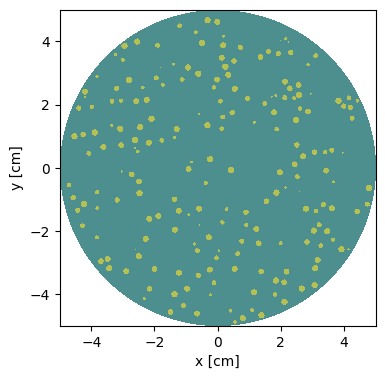

In [165]:
univ.plot(width=(10, 10), pixels=100000)